# Malnutrition in the World

Data comes from [here](https://www.kaggle.com/ruchi798/malnutrition-across-the-globe).

In [1]:
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from lets_plot import *
from lets_plot.bistro.corr import *


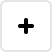
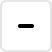
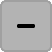
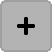
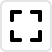
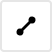
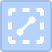
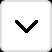
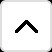
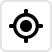
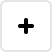
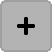
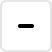
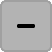
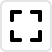
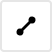
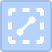
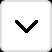
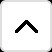
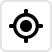

In [2]:
LetsPlot.setup_html()

In [3]:
cwa_df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/"
                     "master/data/malnutrition/country_wise_average.csv")

In [4]:
me_df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/"
                    "master/data/malnutrition/malnutrition_estimates.csv")
me_df = me_df.sort_values(by='Year', ascending=False).drop_duplicates(subset='Country')
me_df = me_df[['Country', 'ISO code', 'LDC', 'LIFD', 'LLDC or SID2']]

In [5]:
df = cwa_df.merge(me_df, on='Country')
df.Country = df.Country.apply(lambda country_name: country_name.capitalize())

### A Bit of Correlation Analysis

Let's look at the correlation coefficients of random variables that correspond to dataframe columns.

In [6]:
corr_plot(df.corr(numeric_only=True)).tiles().palette_RdBu().build() + ggsize(600, 600)

### Choropleth Maps

For each map, the total of children with this disorder in red countries equals to that in blue countries.

In [7]:
cat_cols = ['Income Classification', 'LDC', 'LIFD', 'LLDC or SID2']
num_cols = ['U5 Population (\'000s)']
features = cat_cols + num_cols
targets = ['Severe Wasting', 'Wasting', 'Overweight', 'Stunting', 'Underweight']
targets = list(df[targets].isnull().sum().sort_values().keys())

for target in targets:
    df_train = df[~df[target].isnull()]
    df_test = df[df[target].isnull()]
    X, y = df_train[features], df_train[target]
    X_test = df_test[features]

    parameters = dict(n_estimators=[10, 20, 30, 60], max_depth=[1, 2, 3, 4, 5, 6, 7])
    model = GridSearchCV(RandomForestRegressor(), parameters)
    model.fit(X, y)
    y_pred = model.predict(X_test)
    
    df[target] = df[target].fillna(pd.Series(y_pred, index=X_test.index))

    features = features + [target]

In [8]:
def get_naturalearth_data(data_type="admin_0_countries", columns=["NAME", "geometry"]):
    import shapefile
    from shapely.geometry import shape

    naturalearth_url = "https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/" + \
                       "data/naturalearth/{0}/data.shp?raw=true".format(data_type)
    sf = shapefile.Reader(naturalearth_url)

    gdf = gpd.GeoDataFrame(
        [
            dict(zip([field[0] for field in sf.fields[1:]], record))
            for record in sf.records()
        ],
        geometry=[shape(s) for s in sf.shapes()]
    )[columns]
    gdf.columns = [col.lower() for col in gdf.columns]

    return gdf

In [9]:
def plot_world_decomposition(df, world_gdf, target):
    target_abs = target + ' ABS'
    target_bh = target + ' BH'

    df_copy = df.copy()
    df_copy[target_abs] = df_copy[target] * df_copy['U5 Population (\'000s)'] / 100
    df_copy = df_copy.sort_values(by=target_abs, ascending=False)
    df_copy[target_bh] = df_copy[target_abs].cumsum() < df_copy[target_abs].sum() / 2
    df_copy.loc[df_copy[target_bh].ne(True).idxmax(), target_bh] = True
    df_copy[target_bh] = df_copy[target_bh].apply(lambda r: 'Bigger half' if r else 'Smaller half')

    sifted_df = df_copy[['ISO code', target_abs, target_bh]]
    merged_df = gpd.GeoDataFrame(sifted_df.merge(world_gdf, how='right', left_on='ISO code', right_on='iso_a3'))
    merged_df[target_abs] = merged_df[target_abs].fillna(0)
    merged_df[target_bh] = merged_df[target_bh].fillna('Not in statistics')

    return ggplot() + \
        geom_polygon(aes(fill=target_bh, size='name', alpha=target_abs), \
                     data=merged_df, color='black', \
                     tooltips=layer_tooltips().title('@name')\
                                              .line("{0}|@{{{1}}}".format(target.lower(), target_abs))) + \
        scale_size(name='Country', range=[.3, .3]) + \
        scale_alpha(name=target, range=[.6, 1]) + \
        scale_fill_manual(name=target, values=['#0571b0', '#bababa', '#ca0020']) + \
        ggtitle('%s in the World' % target) + \
        ggsize(600, 450) + \
        theme_void() + theme(legend_position='none')

In [10]:
world_gdf = get_naturalearth_data(columns=["NAME", "ISO_A3", "CONTINENT", "POP_EST", "GDP_MD", "geometry"])
world_gdf.head()

name iso_a3      continent      pop_est    gdp_md  \
0                      Fiji    FJI        Oceania     889953.0      5496   
1                  Tanzania    TZA         Africa   58005463.0     63177   
2                 W. Sahara    ESH         Africa     603253.0       907   
3                    Canada    CAN  North America   37589262.0   1736425   
4  United States of America    USA  North America  328239523.0  21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [11]:
plot_world_decomposition(df, world_gdf, 'Severe Wasting')

In [12]:
plot_world_decomposition(df, world_gdf, 'Wasting')

In [13]:
plot_world_decomposition(df, world_gdf, 'Overweight')

In [14]:
plot_world_decomposition(df, world_gdf, 'Stunting')

In [15]:
plot_world_decomposition(df, world_gdf, 'Underweight')